In [155]:
# Acceso a archivos
import sys
import os

# Visualización de métricas
import matplotlib.pyplot as plt

# Librería que divide en test y train el dataset, permite usar un stratified K-Fold, con la finalidad de revisar hiperparámetros
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.calibration import CalibratedClassifierCV

import numpy as np
import joblib

from catboost import CatBoostClassifier
# Importación de los modelos que componen el ensamblado
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
sys.path.append(os.path.abspath("../funciones"))

from funcionesEntrenamiento import (
    cargar_datos_entrenamiento,
    cargar_datos_prueba,
    imprimir_forma,
    division_train_val,
    reporte_clasificacion,
    crear_matriz_confusion,
    calcular_roc_auc,
    metricas_tpr_fpr,
    hacer_pepinillo
)

In [3]:
X, y = cargar_datos_entrenamiento()

shape, head = imprimir_forma(X)
print("Shape: ", shape)
head

Shape:  (1500, 1368)


,longitud_texto,num_palabras,comida,restriccion,purga,imagen_corporal,ejercicio,polaridad,subjetividad,tag_Anorexia,...,tfidf_1290,tfidf_1291,tfidf_1292,tfidf_1293,tfidf_1294,tfidf_1295,tfidf_1296,tfidf_1297,tfidf_1298,tfidf_1299
0,0.242191,-0.059671,0,0,0,0,0,1.173738,0.353420,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.549985,-1.624910,0,0,0,0,0,-0.336367,-1.128151,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.456454,-0.283276,3,2,0,0,0,0.796212,0.946048,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.333319,0.163935,0,0,0,1,0,1.777780,0.649734,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.790588,-0.730488,0,0,0,1,0,-1.317935,0.946048,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Cargar datos y separar características y columna con las clases con función 
X_test, y_test = cargar_datos_prueba()

shape_test, head_test = imprimir_forma(X_test)
print("Shape test: ", shape_test)
head_test

Shape test:  (250, 1368)


,longitud_texto,num_palabras,comida,restriccion,purga,imagen_corporal,ejercicio,polaridad,subjetividad,tag_Anorexia,...,tfidf_1290,tfidf_1291,tfidf_1292,tfidf_1293,tfidf_1294,tfidf_1295,tfidf_1296,tfidf_1297,tfidf_1298,tfidf_1299
0,-0.395702,-0.506882,0,1,0,0,0,0.972391,1.341134,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.338126,2.399991,0,1,0,1,1,-0.185357,0.538616,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.881716,-0.730488,2,2,0,0,0,-0.336367,-1.128151,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.181439,-0.283276,1,3,0,1,0,-0.336367,-1.128151,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.338126,3.294413,1,3,0,0,0,-0.336367,-1.128151,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X_train, X_val, y_train, y_val = division_train_val(X, y)

train_shape, _ = imprimir_forma(X_train)
val_shape, _ = imprimir_forma(X_val)
print(f"Forma de conjunto de entrenamiento:", train_shape)
print(f"Forma de conjunto de validación:", val_shape)

Forma de conjunto de entrenamiento: (1200, 1368)
Forma de conjunto de validación: (300, 1368)


In [6]:
model_classes = {
    'MLP': MLPClassifier,
    'PAC': PassiveAggressiveClassifier,
    'RF': RandomForestClassifier,
    'SVM': SVC,
    'XGB': XGBClassifier,
}

In [7]:
best_params_dict = {
    'MLP': {
        'activation': 'logistic',
        'hidden_layer_sizes': (300, 200, 100),
        'learning_rate': 'adaptive',
        'max_iter': 300,
        'solver': 'adam',
        'random_state': 22
    },
    'PAC': {
        'C': 0.001,
        'loss': 'squared_hinge',
        'max_iter': 200,
        'random_state': 22
    },
    'RF': {
        'criterion': 'entropy',
        'max_depth': None,
        'max_features': 'log2',
        'min_samples_leaf': 1,
        'min_samples_split': 6,
        'n_estimators': 600,
        'random_state': 22
    },
    'SVM': {
        'C': 400,
        'gamma': 0.001,
        'kernel': 'rbf',
        'probability': True,
        'random_state': 22
    },
    'XGB': {
        'eval_metric': 'logloss',
        'learning_rate': 0.25,
        'max_depth': 1,
        'n_estimators': 600,
        'subsample': 1,
        'random_state': 22
    },
}

In [8]:
n_models = len(model_classes)
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_preds = np.zeros((X_train.shape[0], n_models))  # Meta-training set

In [9]:
for idx, (name, model_class) in enumerate(model_classes.items()):
    print(f"Generating OOF predictions for {name}...")
    temp_oof = np.zeros(X_train.shape[0])
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]


        model = model_class(**best_params_dict[name])
        model.fit(X_tr, y_tr)
        if name != 'PAC':
            temp_oof[val_idx] = model.predict_proba(X_val)[:, 1]
        else:
            temp_oof[val_idx] = model.decision_function(X_val)

    oof_preds[:, idx] = temp_oof

Generating OOF predictions for MLP...
Generating OOF predictions for PAC...


c:\Users\saaso\miniconda3\envs\ia-env\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Generating OOF predictions for RF...
Generating OOF predictions for SVM...
Generating OOF predictions for XGB...


In [10]:
mm_inicial = RandomForestClassifier(random_state=22)
mm_inicial.fit(oof_preds, y_train)

RandomForestClassifier(random_state=22)

In [11]:
X_meta_test = np.zeros((X_test.shape[0], n_models))

for idx, name in enumerate(model_classes.keys()):
    model = joblib.load(f"../../models/model{name}.pkl")  # adjust path if needed
    if name != 'PAC':
        X_meta_test[:, idx] = model.predict_proba(X_test)[:, 1]
    else:
        X_meta_test[:, idx] = model.decision_function(X_test)

c:\Users\saaso\miniconda3\envs\ia-env\Lib\pickle.py:1760: UserWarning: [23:30:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


In [12]:
y_pred_test, y_proba_test, reporte_test = reporte_clasificacion(X_meta_test, y_test, mm_inicial)

print("Classification Report:")
print(reporte_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       116
           1       0.81      0.88      0.84       134

    accuracy                           0.82       250
   macro avg       0.83      0.82      0.82       250
weighted avg       0.83      0.82      0.82       250



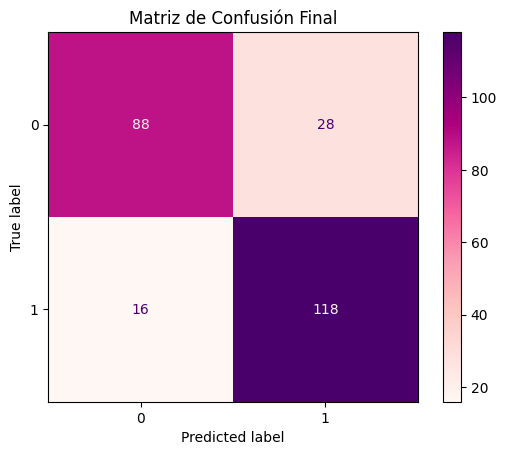

In [13]:
# Matriz de confusión
cm_test, disp_test = crear_matriz_confusion(y_test, y_pred_test)
disp_test.plot(cmap='RdPu')
plt.title("Matriz de Confusión Final")
plt.show()

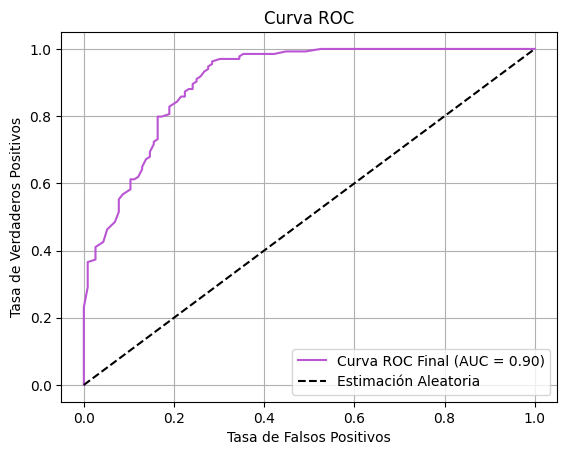

In [14]:
# Predicciones de probabilidad (para curva ROC)
fpr_test, tpr_test, thresholds_test, auc_score_test = calcular_roc_auc(y_test, y_proba_test)

# Gráfica ROC
plt.figure()
plt.plot(fpr_test, tpr_test, color='mediumorchid', label=f"Curva ROC Final (AUC = {auc_score_test:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [15]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR_test, FPR_test = metricas_tpr_fpr(cm_test)

# Mostrar métricas
print(f"AUC: {(auc_score_test * 100):.4f}")
print(f"TPR (True Positive Rate): {(TPR_test * 100):.4f}")
print(f"FPR (False Positive Rate): {(FPR_test * 100):.4f}")

AUC: 90.3371
TPR (True Positive Rate): 88.0597
FPR (False Positive Rate): 24.1379


In [158]:
# Modelo base para encontrar mejores parámetros
mm = CatBoostClassifier(random_state=22, verbose=0, thread_count=1)

# Parámetros a buscar con GridSearchSV  
param_grid = {
    'iterations': [900, 1000],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [5, 7, 9],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 64, 128],
    'random_strength': [1, 5, 10],
    'rsm': [0.8, 1.0],
    'eval_metric': ['AUC',]
}

# Cross-validation estratificada
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=22
)

# GridSearch
grid_search = GridSearchCV(
    estimator=mm,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=3,
    error_score='raise'
)

In [159]:
grid_search.fit(oof_preds, y_train)

Fitting 5 folds for each of 11664 candidates, totalling 58320 fits


KeyboardInterrupt: 

In [102]:
grid_search.best_params_

{'activation': 'logistic',
 'alpha': 0.0005,
 'batch_size': 1000,
 'hidden_layer_sizes': (300, 200, 100, 100),
 'learning_rate': 'constant',
 'learning_rate_init': 0.005,
 'max_iter': 150,
 'solver': 'adam'}

In [149]:
# Creación de modelo con los mejores parámetros
best_mm = MLPClassifier(
    activation = 'logistic',
    alpha = 0.0005,
    batch_size = 1000,
    hidden_layer_sizes = (300, 200, 100, 50, 50),
    learning_rate = 'constant',
    learning_rate_init = 0.005,
    max_iter = 150,
    solver = 'adam',
    random_state = 22
)

best_mm.fit(oof_preds, y_train)

MLPClassifier(activation='logistic', alpha=0.0005, batch_size=1000,
              hidden_layer_sizes=(300, 200, 100, 50, 50),
              learning_rate_init=0.005, max_iter=150, random_state=22)

In [150]:
y_pred_test, y_proba_test, reporte_test = reporte_clasificacion(X_meta_test, y_test, best_mm)

print("Classification Report:")
print(reporte_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       116
           1       0.80      0.91      0.85       134

    accuracy                           0.83       250
   macro avg       0.84      0.83      0.83       250
weighted avg       0.84      0.83      0.83       250



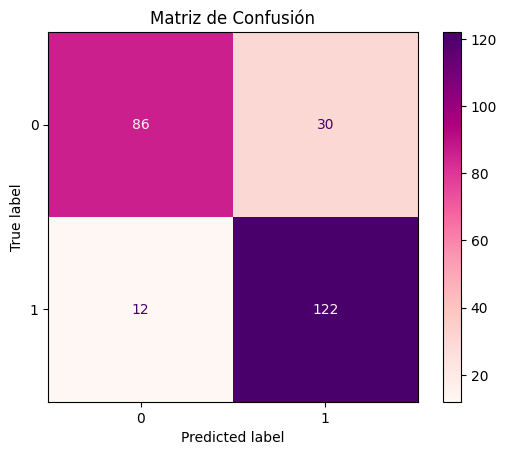

In [151]:
# Matriz de confusión
cm, disp = crear_matriz_confusion(y_test, y_pred_test)
disp.plot(cmap='RdPu')
plt.title("Matriz de Confusión")
plt.show()

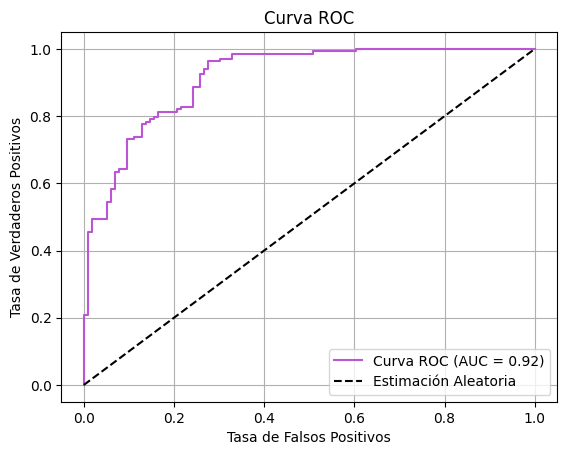

In [152]:
# Predicciones de probabilidad (para curva ROC)
fpr, tpr, thresholds, auc_score = calcular_roc_auc(y_test, y_proba_test)

# Gráfica de ROC
plt.figure()
plt.plot(fpr, tpr, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [153]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR, FPR = metricas_tpr_fpr(cm)

# Mostrar métricas
print(f"AUC: {(auc_score * 100):.4f}")
print(f"TPR (Tasa de Positivos Verdaderos): {(TPR * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR * 100):.4f}")

AUC: 91.5401
TPR (Tasa de Positivos Verdaderos): 91.0448
FPR (Tasa de Falsos Positivos): 25.8621
